# HANDWRITTEN DIGITS
We want to build a classifier to recognize handwritten digits. First of all, we load the needed dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
digits = datasets.load_digits()

Every digit is saved in an $8 \times 8$ square, where at each square there is a number: the higher the number, the more black the considered pixel. So every digit is represented by $64$ numbers.

The first thing we do is to try to reduce the number of parameters actually relevant for the classification. We use the Isomap algorithm, but we need to specify the final number of parameters we want to have. In this case, we choose 5 components:

In [3]:
sc = StandardScaler()
sc.fit(digits.data)
digits_sc = sc.transform(digits.data)
model_DR = Isomap(n_neighbors = 10, n_components=5)
model_DR.fit(digits_sc)

Isomap(n_components=5, n_neighbors=10)

In [4]:
reduced = model_DR.transform(digits_sc)

Now we plot some projections of the data, to look if we can see some groups of digits. Every colour represent the true label.

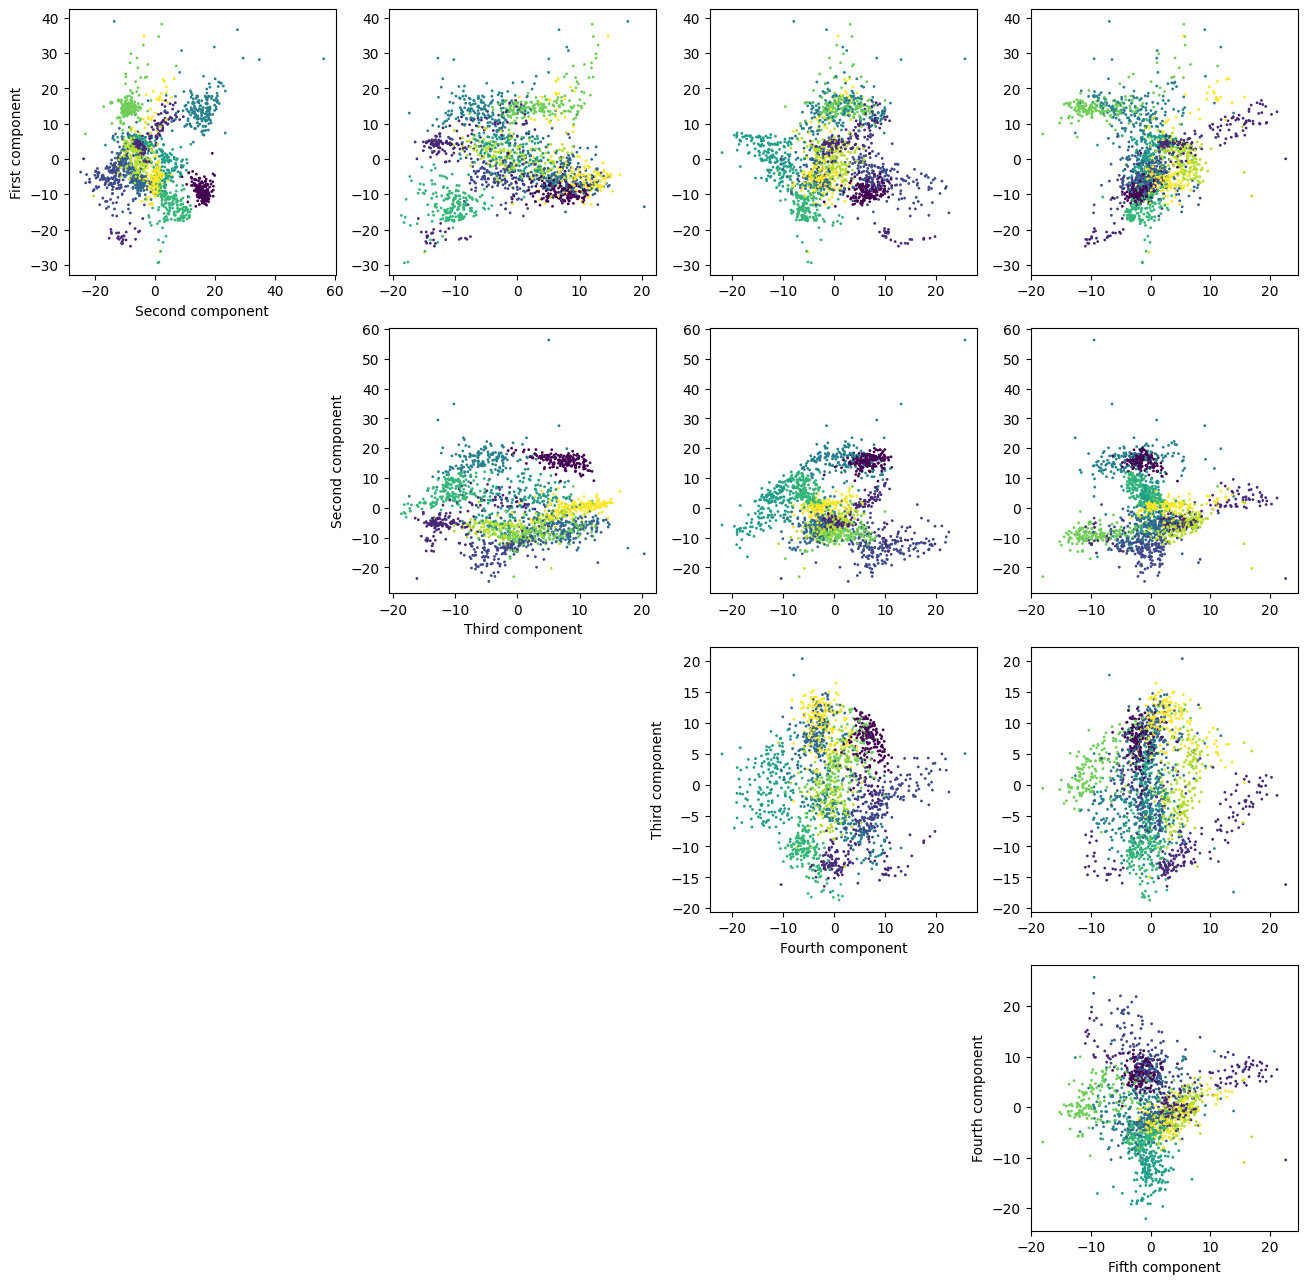

In [5]:
plt.figure(figsize = [20, 20])
labels = ["First", "Second", "Third", "Fourth", "Fifth"]

for i in range(0, 5):
    for j in range (i+1, 5):
        plt.subplot(5, 5, 5 * i + j)
        plt.scatter(reduced[:, j], reduced[:,i], c = digits.target, s=1)
        if j == i + 1:
            plt.xlabel(labels[j] + " component")
            plt.ylabel(labels[i] + " component")

As you can see, there is some division between some of the groups of digits.

It's time to build the classifier. We'll use the Logistic Regression algorithm. As we said before, we don't really now which is the best number of reduced components that allow the best performance. So we'll try to build a classifier for every number of possible dimensions, and compute the accuracy for each. We plot the results:

In [6]:
targ_pred = np.zeros((len(digits.feature_names), int(len(reduced) * 0.2) + 1))
targ_test = np.zeros((len(digits.feature_names), int(len(reduced) * 0.2) + 1))
accuracy = np.zeros(len(digits.feature_names))

for i in tqdm(range(len(digits.feature_names))):
    model_DR = Isomap(n_neighbors = 10, n_components=i + 1)
    model_DR.fit(digits_sc)
    reduced = reduced = model_DR.transform(digits_sc)
    red_train, red_test, targ_train, targ_test[i] = train_test_split(reduced, digits.target, test_size=0.2)
    model_LR = LogisticRegression(solver='sag', max_iter = 3000) #Max_iter chosen to guarantee the convergence of the algorithm for every i
    model_LR.fit(red_train, targ_train)
    targ_pred[i] = model_LR.predict(red_test)
    accuracy[i] = accuracy_score(targ_test[i], targ_pred[i])

100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [02:12<00:00,  2.07s/it]


Text(0.5, 1.0, 'Accuracy vs number of components')

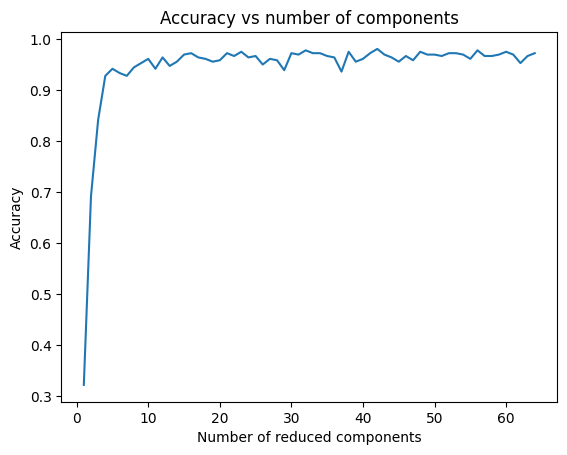

In [7]:
plt.plot(range(1, len(digits.feature_names) + 1), accuracy)
plt.xlabel("Number of reduced components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of components")

Now we can make a decision: we choose the classifier with the minimum number of components that allow an accuracy greater than 95%, which is (note: the number can vary according to how the dataset is split into training and test set):

In [8]:
for i in range(len(digits.feature_names)):
    if accuracy[i] > 0.95:
        best = i
        break

print("Minimum number of components: {}".format(best + 1))

Minimum number of components: 9


Now we can also look at the confution matrix:

In [9]:
confusion_matrix(targ_test[best], targ_pred[best])

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4, 36,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 31,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0, 39,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 43,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  1,  1],
       [ 0,  0,  0,  1,  1,  0,  0,  0, 32,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 29]])

You can see that in general the errors occur when the two digit are quite similar to write.